In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/checkpoint-7500-17500/check_point_7500_17500/config.json
/kaggle/input/checkpoint-7500-17500/check_point_7500_17500/tokenizer.json
/kaggle/input/checkpoint-7500-17500/check_point_7500_17500/tokenizer_config.json
/kaggle/input/checkpoint-7500-17500/check_point_7500_17500/model.safetensors
/kaggle/input/checkpoint-7500-17500/check_point_7500_17500/special_tokens_map.json
/kaggle/input/checkpoint-7500-17500/check_point_7500_17500/sentencepiece.bpe.model
/kaggle/input/checkpoint-0-10000/config.json
/kaggle/input/checkpoint-0-10000/tokenizer.json
/kaggle/input/checkpoint-0-10000/tokenizer_config.json
/kaggle/input/checkpoint-0-10000/model.safetensors
/kaggle/input/checkpoint-0-10000/special_tokens_map.json
/kaggle/input/checkpoint-0-10000/sentencepiece.bpe.model
/kaggle/input/vihsd-dataset/ViHSD/dev.csv
/kaggle/input/vihsd-dataset/ViHSD/train.csv
/kaggle/input/vihsd-dataset/ViHSD/test.csv


In [2]:
%pip install datasets evaluate transformers[sentencepiece]
%pip install accelerate
#%pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModel, get_scheduler,  get_linear_schedule_with_warmup, AutoModelForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from accelerate import Accelerator
import evaluate
import time
from datasets import load_metric

2024-06-17 16:16:17.997074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 16:16:17.997175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 16:16:18.104977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
if torch.cuda.is_available():
    # to use GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU is:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
print(torch.__version__)
print(torch.version.cuda)
#print(torch.randn(1).cuda())

There are 1 GPU(s) available.
GPU is: Tesla P100-PCIE-16GB
2.1.2
12.1


In [5]:
checkpoint = "uitnlp/visobert"
saved_checkpoint = "/kaggle/input/checkpoint-7500-17500/check_point_7500_17500/"
train_path = "/kaggle/input/vihsd-dataset/ViHSD/train.csv"
test_path = "/kaggle/input/vihsd-dataset/ViHSD/test.csv"
val_path = "/kaggle/input/vihsd-dataset/ViHSD/dev.csv"

In [6]:
data_train = pd.read_csv(train_path)
data_val = pd.read_csv(val_path)
data_test = pd.read_csv(test_path)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(saved_checkpoint,local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(saved_checkpoint,local_files_only=True)

In [7]:
data_train = data_train.dropna()
data_val = data_val.dropna()
data_test = data_test.dropna()

input_train_data = data_train["free_text"].tolist()
input_val_data = data_val["free_text"].tolist()
input_test_data = data_test["free_text"].tolist()

len(input_train_data),len(input_val_data),len(input_test_data)

(24046, 2672, 6680)

In [8]:
data_train.head(3)
# sldkjf

,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,1
2,Đậu Văn Cường giờ giống thằng sida hơn à,0


In [9]:
data_train_path = data_train[15000:]
data_val_path = data_val[:]
data_test_path = data_test[:]

print(len(data_train_path),len(data_val_path),len(data_test_path))

input_train_data_path = data_train_path["free_text"].tolist()
label_train_data_path = data_train_path['label_id'].tolist()

input_val_data_path = data_val_path["free_text"].tolist()
label_val_data_path = data_val_path['label_id'].tolist()

input_test_data_path = data_test_path["free_text"].tolist()
label_test_data_path = data_test_path['label_id'].tolist()

9046 2672 6680


In [10]:
tokenized_train = tokenizer(input_train_data_path, padding= "max_length", max_length=512, truncation=True, return_tensors="pt")
tokenized_val = tokenizer(input_val_data_path, padding= "max_length", max_length=512, truncation=True, return_tensors="pt")
tokenized_test = tokenizer(input_test_data_path, padding= "max_length", max_length=512, truncation=True, return_tensors="pt")

# tokenized_train = tokenizer(input_train_data_path, padding= True, max_length=514, truncation=True, return_tensors="pt")
# tokenized_val = tokenizer(input_val_data_path, padding= True, max_length=514, truncation=True, return_tensors="pt")
# tokenized_test = tokenizer(input_test_data_path, padding= True, max_length=514, truncation=True, return_tensors="pt")

In [11]:
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(tokenized_train['input_ids'], tokenized_train['attention_mask'], torch.tensor(label_train_data_path).type(torch.LongTensor))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our val set
validation_data = TensorDataset(tokenized_val['input_ids'], tokenized_val['attention_mask'], torch.tensor(label_val_data_path).type(torch.LongTensor))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
test_data = TensorDataset(tokenized_test['input_ids'], tokenized_test['attention_mask'], torch.tensor(label_test_data_path).type(torch.LongTensor))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
print(len(train_dataloader), len(validation_dataloader), len(test_dataloader))

566 167 418


In [12]:
model.resize_token_embeddings(len(tokenizer))

Embedding(15002, 768, padding_idx=1)

In [ ]:
# Optimizer & Learning Rate Scheduler
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

# Number of training epochs
epochs = 12
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
print(total_steps)
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
print("total steps: ",total_steps)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(total_steps))

model.train()
t0 = time.time()
for epoch in range(epochs):
    for batch in train_dataloader:
#        print(batch[0].shape)
#        print(batch[1].shape)
#        print(batch[2].shape)
        batch = {'input_ids': batch[0].to(device), 'labels': batch[2].to(device),'attention_mask': batch[1].to(device)}
        outputs = model(**batch)
        loss = outputs[0]
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    t1 = format(time.time() - t0)
    t0 = time.time()
    print("    epoch ", epoch+1, " trainning completed in ", t1 ,"s , validating model")
    predictions,true_labels =[],[]
    model.eval()
    metric = evaluate.load("glue", "mrpc")
    for batch in validation_dataloader:
        label = batch[2].to(device)
        #print(label)
        batch = {'input_ids': batch[0].to(device),'attention_mask': batch[1].to(device)}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits.detach().cpu().numpy()
        prediction = np.argmax(logits, axis=-1)
        metric.add_batch(predictions=prediction, references=label)
        for i in prediction:
            predictions.append(i)
        for j in label.to('cpu').numpy():
            true_labels.append(j) 
    t2 = format(time.time() - t0)
    t0 = time.time()
    print("    validating result: ",metric.compute(), " in ", t2,"s")
    print("    --------------------------------------")

In [13]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
 
def custom_metrics(eval_pred):
    metric_precision = load_metric("precision")
    metric_recall = load_metric("recall")
    metric_f1 = load_metric("f1")
    metric_f1_accuracy = load_metric("accuracy")
    
    logits, labels = eval_pred

    precision = metric_precision.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1_micro = metric_f1.compute(predictions=predictions, references=labels, average="micro")["f1"]
    f1_macro = metric_f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    accuracy = metric_f1_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1_micro": f1_micro, "f1_macro": f1_macro, "accuracy": accuracy}
def team_metric(eval_pred):
    logits, labels = eval_pred
    # Tính toán các chỉ số đánh giá
    f1_micro = f1_score(labels, logits, average='micro')
    f1_macro = f1_score(labels, logits, average='macro')
    accuracy = accuracy_score(labels, logits)
    precision_macro = precision_score(labels, logits, average='macro')
    recall_macro = recall_score(labels, logits, average='macro')
    return {"precision-macro": precision_macro, "recall-macro": recall_macro, "f1_micro": f1_micro, "f1_macro": f1_macro, "accuracy": accuracy}

In [14]:
import evaluate

predictions,true_labels =[],[]
model.to(device)
model.eval()
metric = evaluate.load("glue", "mrpc")
progress_eval_bar = tqdm(range(len(test_dataloader)-1))

for batch in test_dataloader:
    label = batch[2].to(device)
    #print(label)
    batch = {'input_ids': batch[0].to(device),'attention_mask': batch[1].to(device)}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits.detach().cpu().numpy()
    prediction = np.argmax(logits, axis=-1)
    metric.add_batch(predictions=prediction, references=label)
    for i in prediction:
        predictions.append(i)
    for j in label.to('cpu').numpy():
        true_labels.append(j) 
    progress_eval_bar.update(1)
a = metric.compute()
b = custom_metrics((predictions, true_labels))
c = team_metric((predictions, true_labels))
print("result: ", a)
print("detail: ", b)
print("team_metric: ", c)

  0%|          | 0/417 [00:00<?, ?it/s]

/tmp/ipykernel_34/1690346821.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_precision = load_metric("precision")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


result:  {'accuracy': 0.9028443113772455, 'f1': 0.7045971779699591}
detail:  {'precision': 0.9028443113772455, 'recall': 0.9028443113772455, 'f1_micro': 0.9028443113772455, 'f1_macro': 0.823229342366687, 'accuracy': 0.9028443113772455}
team_metric:  {'precision-macro': 0.831501385875359, 'recall-macro': 0.815647124612441, 'f1_micro': 0.9028443113772455, 'f1_macro': 0.823229342366687, 'accuracy': 0.9028443113772455}


Text(95.72222222222221, 0.5, 'Predicted Hate Speech Label')

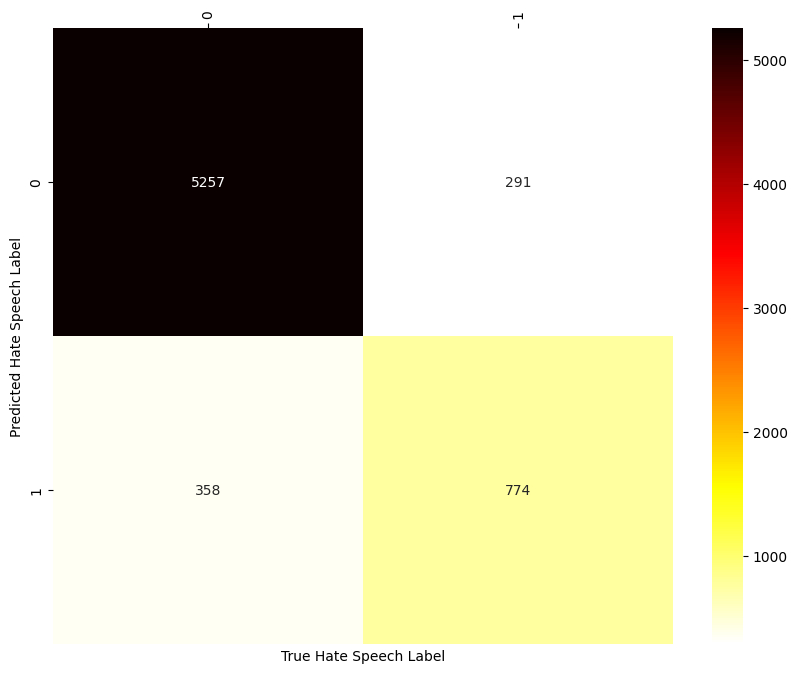

In [15]:
import seaborn as sns
# return class label
class_label = np.unique(true_labels)
# get confusion matrix
cm = confusion_matrix(true_labels,
                      predictions)
# covert it to dataframe for plotting
cm_df = pd.DataFrame(cm,
                     index = class_label,
                     columns = class_label)
# plot it
plt.figure(figsize = (10,8))
g = sns.heatmap(cm_df, cmap = 'hot_r', annot=True, fmt='g')
g.xaxis.set_ticks_position("top")
g.tick_params(axis='x', rotation=90)
g.set_xlabel("True Hate Speech Label")
g.set_ylabel("Predicted Hate Speech Label")

In [16]:
model.save_pretrained('/kaggle/working/')
tokenizer.save_pretrained('/kaggle/working/')

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/sentencepiece.bpe.model',
 '/kaggle/working/added_tokens.json',
 '/kaggle/working/tokenizer.json')